### Import statements

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import psycopg2
import seattle_neighborhoods
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def database_connect(dbnm, username):
    '''
    INPUT: name of existing postgres database, username
    OUTPUT: database connection and cursor
    Take database name and username and establish conncetion to database
    '''
    conn = psycopg2.connect(dbname=dbnm, user=username, host='/tmp')
    c = conn.cursor()
    return conn, c

In [3]:
def remove_rows(df, colname, colval):
    '''
    INPUT: dataframe, column name, column value
    OUTPUT: dataframe
    take a dataframe and remove all rows in which the value for colname = colval
    '''
    return df[df[colname] != colval]

In [9]:
def remove_outliers(df, colname, iqr_mult):
    '''
    INPUT: dataframe, column name, multiplier for inter quartile range
    OUTPUT: dataframe
    take a dataframe and return a dataframe with outliers removed
    '''
    print colname
    q1 = df[colname].quantile(.25)
    q3 = df[colname].quantile(.75)
    iqr = df[colname].quantile(.75) - df[colname].quantile(.25)  # calculate interquartile range
    df = df[df[colname] >= q1 - iqr * iqr_mult]  # remove low outliers
    df = df[df[colname] <= q3 + iqr * iqr_mult]  # remove high outliers
    return df

### Connect to postgres SQL database and extract housing data for 2015 and 2015

In [10]:
conn, c = database_connect('housingdata_clean', 'sydneydecoto')

c.execute("SELECT * FROM housing_data LIMIT 10")
data = c.fetchall()

c.execute("SELECT v2015 FROM housing_data")
val2015 = c.fetchall()
c.execute("SELECT v2016 FROM housing_data")
val2016 = c.fetchall()
c.execute("SELECT hood FROM housing_data")
hoods = c.fetchall()
conn.commit()
conn.close()

### Calculate percent increase in value from 2015 to 2016

In [11]:
df = pd.DataFrame()
df['Neighborhood'] = [hood_name[0] for hood_name in hoods]
df['value_2015'] = [v[0] for v in val2015]
df['value_2016'] = [v[0] for v in val2016]
df['pct_inc16'] = (df['value_2016'] - df['value_2015']) / df['value_2015']*100.

print df.head()

     Neighborhood  value_2015  value_2016  pct_inc16
0        Atlantic      273000      294000   7.692308
1     Portage Bay     1318000     1443000   9.484067
2   Highland Park      198000      227000  14.646465
3      Holly Park      303000      337000  11.221122
4  Matthews Beach      420000      449000   6.904762


### Data cleaning

In [12]:
'''remove null values, zero home values'''
df.dropna(axis=0, inplace=True)
df = remove_rows(df, 'value_2015', 0)
df = remove_rows(df, 'value_2016', 0)
df = remove_outliers(df, 'pct_inc16', 3)
df.info()

pct_inc16
<class 'pandas.core.frame.DataFrame'>
Int64Index: 32324 entries, 0 to 36529
Data columns (total 4 columns):
Neighborhood    32324 non-null object
value_2015      32324 non-null int64
value_2016      32324 non-null int64
pct_inc16       32324 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.2+ MB


### Find neighborhoods with maximum and minimum value increase between 2015 and 2015

In [13]:
grouped = df.groupby(['Neighborhood']).mean()
hoods = np.array(grouped.index)
pctincs = np.array(grouped['pct_inc16'])

print '{} has maximum value increase of {}%'.format(hoods[pctincs == max(pctincs)][0], round(max(pctincs),1))
print '{} has minimum value increase of {}%'.format(hoods[pctincs == min(pctincs)][0], round(min(pctincs),1))

Sand Point has maximum value increase of 14.9%
Industrial District has minimum value increase of 3.6%


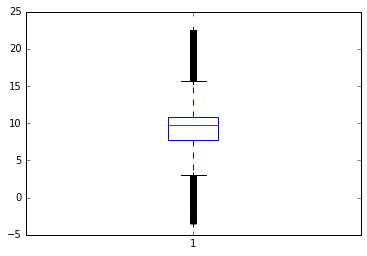

In [14]:
plt.boxplot(df['pct_inc16'])
plt.show()

In [15]:
q1 = df.pct_inc16.quantile(0.25)
q3 = df.pct_inc16.quantile(0.75)
iqr = q3 - q1

### Load building permit data and clean dataframe

In [17]:
df_permits = pd.read_csv('data/permitting.csv')  # Load the data from csv
dates = pd.to_datetime(df_permits['Application Date'])  # Convert Application Date column to datetime
df_permits['year'] = [d.year for d in dates]   # Retrieve year from date and add year column to dataframe

In [18]:
df_permits = df_permits[df_permits.year == 2015]  # keep all 2015 data
df_permits.dropna(axis=0, subset=['Latitude', 'Longitude'], inplace=True)  # drop rows with no latitude and longitude
print df_permits.head()

      Application/Permit Number   Permit Type           Address  \
7121                    6504528  Construction    2700 4TH AVE S   
7122                    6511706  Construction  9616 27TH AVE NW   
7123                    6511726  Construction   5019 57TH AVE S   
7124                    6511226  Construction  5520 17TH AVE NE   
7125                    6511623  Construction   1413 E ALOHA ST   

                                            Description  \
7121  Construct interior alterations to combine two ...   
7122  Alterations to single family residence, subjec...   
7123  Interior remodel to existing single family res...   
7124  Construct alterations to basement of existing ...   
7125  Construct repairs to a fire damaged single fam...   

                    Category Action Type       Work Type       Value  \
7121              COMMERCIAL     ADD/ALT     Plan Review   $20000.00   
7122  SINGLE FAMILY / DUPLEX     ADD/ALT  No plan review    $8000.00   
7123  SINGLE FAMILY / DUPL